<a href="https://colab.research.google.com/github/AlessLG/practicas_curvas-de-rotacion/blob/main/ajustes_curvas_rotacion_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# G = 4.3e-3 # pc • (km/s)² / M_⊙
G = 4.3e-6 # kpc • (km/s)² / M_⊙

descargar_figuras = False

def v_Hernquist(r, M, a):
    return np.sqrt(G*M*r/(a+r)**2)

def v_plummer(r, M, a):
    return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))

def v_nfw(r, A, r_s):
    return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))

def v_sol_reparam(r, rho_c, a):
    B = rho_c * (a**16)
    return v_sol(r, B, a)

def v_sol(r, B, a):
    poly_part = (
        -0.177069 * a**13 * r
        + 0.225911 * a**11 * r**3
        + 0.039069 * a**9 * r**5
        + 0.0039039 * a**7 * r**7
        + 0.000229089 * a**5 * r**9
        + 7.36645e-6 * a**3 * r**11
        + 1.00552e-7 * a * r**13
    )
    arctan_poly_part = (
        0.586978 * a**14
        + 0.373905 * a**12 * r**2
        + 0.102076 * a**10 * r**4
        + 0.0154815 * a**8 * r**6
        + 0.00140882 * a**6 * r**8
        + 7.69216e-5 * a**4 * r**10
        + 2.33329e-6 * a**2 * r**12
        + 3.03327e-8 * r**14
    )
    arctan_term = arctan_poly_part * np.arctan(0.301662 * r / a)
    numerator_content = B * G * (poly_part + arctan_term)
    denominator = a**13 * r * (a**2 + 0.091 * r**2)**7
    term_inside_sqrt = np.maximum(0, (4 * np.pi * numerator_content) / denominator)
    velocity = np.sqrt(term_inside_sqrt)
    return velocity

def v_disk_miyamoto(r, M_d, a_d, b_d):
    # (R^2 + (a+b)^2)^(3/2)
    denom = (r**2 + (a_d + b_d)**2)**(1.5)
    v_sq = (G * M_d * r**2) / denom
    return np.sqrt(v_sq)

def v_total_model(r, params, halo_func):
    # params espera: [p1_halo, p2_halo, M_disk, a_disk, b_disk]
    p_halo = params[0:2]      # Primeros 2 son del halo
    p_disk = params[2:]       # Los siguientes 3 son del disco (M, a, b)
    v_h = halo_func(r, *p_halo)
    v_d = v_disk_miyamoto(r, *p_disk)
    return np.sqrt(v_h**2 + v_d**2)

In [ ]:
# @title
def fit_and_plot_rotation_curve(file_path, show_plot=True, save_plot_path=None):
    """
    Carga datos de una curva de rotación, ajusta 4 modelos de halo,
    imprime los resultados y genera gráficos de ajuste y residuos.
    """

    data = np.genfromtxt(file_path, delimiter='\t')
    r_data, v_data, err_data = data[:, 0], data[:, 1], data[:, 2]

    # --- 2. Preparación de Modelos y Ajuste ---
    model_config = {
        # "Hernquist": {"func": v_Hernquist, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        # "Plummer":   {"func": v_plummer, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        # "NFW":       {"func": v_nfw, "x0": [1e11, 10.0], "param_labels": ["A", "r_s"]},
        "Solitón":   {"func": v_sol_reparam, "x0": [1e7, 10.0], "param_labels": ["ρ_c", "a"]},
    }

    resultados = {}

    def residuals(params, func, r, v_obs, v_err):
        return (func(r, *params) - v_obs) / v_err

    for name, config in model_config.items():
        res = least_squares(residuals, config["x0"], args=(config["func"], r_data, v_data, err_data), bounds=([0, 0], [np.inf, np.inf]))
        params, J = res.x, res.jac
        try:
            errors = np.sqrt(np.diag(np.linalg.inv(J.T @ J)))
        except np.linalg.LinAlgError:
            errors = [np.inf, np.inf]

        dof = len(v_data) - len(params)
        chi2_red = np.sum(res.fun**2) / dof if dof > 0 else np.inf
        resultados[name] = {"params": params, "errors": errors, "chi2_red": chi2_red}

    # --- 3. Impresión de Resultados ---
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n--- Resultados de Ajustes para la Galaxia: {galaxy_name} ---")
    for name, res in sorted(resultados.items(), key=lambda item: item[1]['chi2_red']):
        p1, p2 = res['params']
        e1, e2 = res['errors']
        l1, l2 = model_config[name]["param_labels"]
        unit = "M⊙/kpc³" if name == "Solitón" else "M⊙"

        print(f"{name}: (χ²_red = {res['chi2_red']:.3f})")
        print(f"  {l1:<5} = ({p1:.2e} ± {e1:.1e}) {unit}")
        print(f"  {l2:<5} = ({p2:.2f} ± {e2:.2f}) kpc")
        print("-" * 45)

    # --- 4. Generación del Gráfico de Ajuste ---
    if not (show_plot or save_plot_path):
        return resultados

    colors = {'Plummer': 'g', 'Solitón': 'k', 'Hernquist': 'b', 'NFW': 'r'}
    styles = {'Plummer': '-', 'Solitón': ':', 'Hernquist': '--', 'NFW': '-.'}
    markers = {'Plummer': 'o', 'Solitón': 's', 'Hernquist': '^', 'NFW': 'D'}

    plt.figure(figsize=(6, 4))
    d = np.linspace(0.1, r_data.max(), 200)

    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos SPARC', capsize=4, markersize=5)

    for name, res in resultados.items():
        plt.plot(d, model_config[name]["func"](d, *res['params']),
                 color=colors[name], linestyle=styles[name],
                 label=f'{name} (χ²_red={res["chi2_red"]:.2f})')

    plt.xlabel('Radio (kpc)')
    plt.ylabel('Velocidad (km/s)')
    plt.title(f'Ajuste de Curva de Rotación para {galaxy_name}')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    # plt.xlim(0)
    # plt.ylim(0)

    if save_plot_path:
        plt.savefig(f"{galaxy_name}_fit.pdf", bbox_inches='tight')
    if show_plot:
        plt.show()
    plt.close()
    return resultados

In [ ]:
def fit_and_plot_rotation_curve(file_path, show_plot=True, save_plot_path=None):
    """
    Carga datos, ajusta modelos, imprime resultados y genera gráficos de ajuste
    con bandas de confianza y residuos.
    """
    data = np.genfromtxt(file_path, delimiter='\t')
    r_data, v_data, err_data = data[:, 0], data[:, 1], data[:, 2]

    # x0 ahora tiene 5 valores: [Halo_1, Halo_2, Disk_M, Disk_a, Disk_b]
    initial_guess_std = [1e11, 20.0,  5e10, 4.0, 0.5]
    initial_guess_sol = [1e7, 10.0,  5e10, 4.0, 0.5]

    model_config = {
        "Hernquist": {"func": v_Hernquist, "x0": initial_guess_std, "labels": ["M_halo", "a_halo"]},
        "Plummer":   {"func": v_plummer,   "x0": initial_guess_std, "labels": ["M_halo", "a_halo"]},
        "NFW":       {"func": v_nfw,       "x0": initial_guess_std, "labels": ["A_halo", "rs_halo"]},
        "Solitón":   {"func": v_sol_reparam, "x0": initial_guess_sol, "labels": ["ρc_halo", "a_halo"]},
    }

    resultados = {}

    def residuals(params, halo_func, r, v_obs, v_err):
        v_teorica = v_total_model(r, params, halo_func)
        return (v_teorica - v_obs) / v_err

    for name, config in model_config.items():
            # bounds: 5 parámetros positivos
            bounds_min = [0, 0, 0, 0, 0]
            bounds_max = [np.inf, np.inf, np.inf, np.inf, np.inf]

            res = least_squares(
                residuals,
                config["x0"],
                args=(config["func"], r_data, v_data, err_data),
                bounds=(bounds_min, bounds_max)
            )

            params = res.x
            # Cálculo de errores y Chi2
            try:
                # La matriz Jacobiana ahora es de Nx5
                cov = np.linalg.inv(res.jac.T @ res.jac)
                errors = np.sqrt(np.diag(cov))
            except:
                errors = np.full_like(params, np.inf)

            dof = len(v_data) - len(params)
            chi2_red = np.sum(res.fun**2) / dof if dof > 0 else np.inf

            resultados[name] = {
                "params": params,
                "errors": errors,
                "chi2_red": chi2_red,
                "func": config["func"] # Guardamos la función del halo para usarla al plotear
            }

    # --- Reporte ---
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n=== Resultados Galaxia: {galaxy_name} (Halo + Disco Miyamoto-Nagai) ===")

    for name, res in sorted(resultados.items(), key=lambda x: x[1]['chi2_red']):
        p = res['params']
        e = res['errors']
        labels = model_config[name]["labels"]

        print(f"Modelo {name} (χ²_red = {res['chi2_red']:.3f})")
        # Parámetros del Halo
        print(f"  [Halo] {labels[0]:<8}: {p[0]:.2e} ± {e[0]:.1e}")
        print(f"  [Halo] {labels[1]:<8}: {p[1]:.2f} ± {e[1]:.2f} kpc")
        # Parámetros del Disco (comunes a todos)
        print(f"  [Disco] Masa    : {p[2]:.2e} ± {e[2]:.1e} M⊙")
        print(f"  [Disco] a (rad) : {p[3]:.2f} ± {e[3]:.2f} kpc")
        print(f"  [Disco] b (vert): {p[4]:.2f} ± {e[4]:.2f} kpc")
        print("-" * 50)

    # --- Gráficos ---
    d = np.linspace(0.1, r_data.max(), 200)

    # 1. Curvas de Rotación (Mejor Ajuste Total)
    plt.figure(figsize=(10, 6))
    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos', alpha=0.6)

    colors = {'Plummer': 'g', 'Solitón': 'k', 'Hernquist': 'b', 'NFW': 'r'}
    for name, res in resultados.items():
        # Calculamos la curva total usando los 5 parámetros
        v_tot = v_total_model(d, res['params'], res['func'])
        plt.plot(d, v_tot, color=colors[name], label=f'{name} Total')

        # Opcional: Si quieres ver la contribución del disco para el mejor modelo (ej. Soliton)
        if name == 'Solitón':
             p = res['params']
             v_disk_only = v_disk_miyamoto(d, p[2], p[3], p[4])
             v_halo_only = res['func'](d, p[0], p[1])
             plt.plot(d, v_disk_only, 'k:', alpha=0.5, label='Solitón (Solo Disco)')
             plt.plot(d, v_halo_only, 'k--', alpha=0.5, label='Solitón (Solo Halo)')

    plt.title(f"Ajuste Halo + Disco para {galaxy_name}")
    plt.xlabel("Radio (kpc)")
    plt.ylabel("Velocidad (km/s)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 2. Gráfico de Residuos Unificado
    plt.figure(figsize=(10, 5))
    plt.axhline(0, color='black', lw=1)
    plt.fill_between(r_data, -err_data, err_data, color='gray', alpha=0.2, label='Error Obs.')

    markers = {'Plummer': 'o', 'Solitón': 's', 'Hernquist': '^', 'NFW': 'D'}
    for name, res in resultados.items():
        # Calculamos velocidad en los puntos de los datos
        v_model = v_total_model(r_data, res['params'], res['func'])
        resid = v_data - v_model
        plt.plot(r_data, resid, marker=markers[name], ls='none', color=colors[name], alpha=0.7, label=name)

    plt.title(f"Residuos (Datos - Modelo Total) para {galaxy_name}")
    plt.xlabel("Radio (kpc)")
    plt.ylabel("Residuo (km/s)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return resultados


=== Resultados Galaxia: F563-1 (Halo + Disco Miyamoto-Nagai) ===
Modelo Hernquist (χ²_red = 4.332)
  [Halo] M_halo  : 1.00e+11 ± 2.3e+11
  [Halo] a_halo  : 20.08 ± 30.07 kpc
  [Disco] Masa    : 5.00e+10 ± 2.7e+10 M⊙
  [Disco] a (rad) : 5.17 ± 11514504.37 kpc
  [Disco] b (vert): 1.67 ± 11514504.12 kpc
--------------------------------------------------
Modelo Plummer (χ²_red = 4.464)
  [Halo] M_halo  : 1.00e+11 ± 2.3e+11
  [Halo] a_halo  : 20.07 ± 46.60 kpc
  [Disco] Masa    : 5.00e+10 ± 6.8e+10 M⊙
  [Disco] a (rad) : 4.88 ± 7983660.83 kpc
  [Disco] b (vert): 1.38 ± 7983660.97 kpc
--------------------------------------------------
Modelo Solitón (χ²_red = 5.287)
  [Halo] ρc_halo : 1.00e+07 ± 5.3e+07
  [Halo] a_halo  : 5.73 ± 3.77 kpc
  [Disco] Masa    : 5.00e+10 ± 1.8e+11 M⊙
  [Disco] a (rad) : 4.94 ± 5931241.45 kpc
  [Disco] b (vert): 1.44 ± 5931241.34 kpc
--------------------------------------------------
Modelo NFW (χ²_red = 78.108)
  [Halo] A_halo  : 1.00e+11 ± 2.8e+11
  [Halo] rs_h

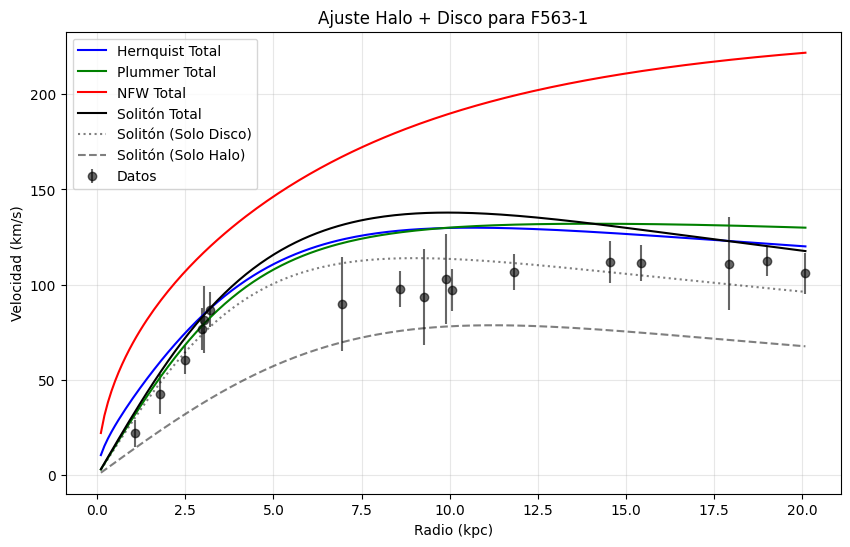

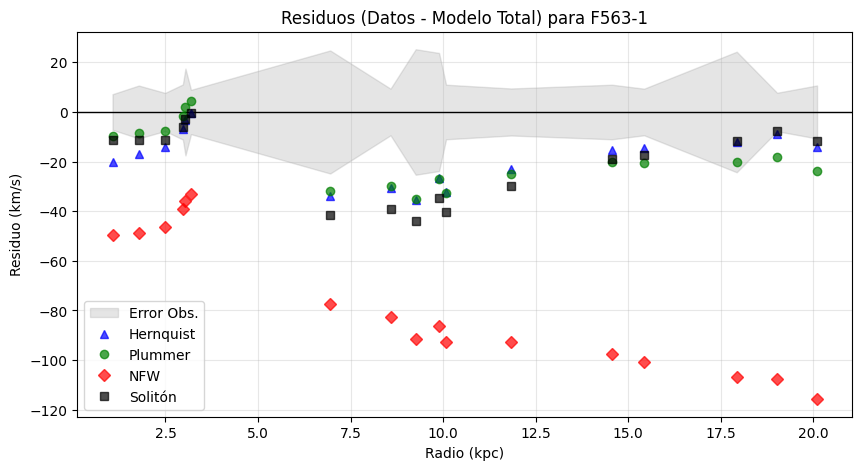


=== Resultados Galaxia: F563-V2 (Halo + Disco Miyamoto-Nagai) ===
Modelo Plummer (χ²_red = 1.723)
  [Halo] M_halo  : 1.00e+11 ± 5.3e+12
  [Halo] a_halo  : 20.02 ± 504.88 kpc
  [Disco] Masa    : 5.00e+10 ± 1.4e+11 M⊙
  [Disco] a (rad) : 4.38 ± 6715311.93 kpc
  [Disco] b (vert): 0.88 ± 6715311.53 kpc
--------------------------------------------------
Modelo Hernquist (χ²_red = 1.855)
  [Halo] M_halo  : 1.00e+11 ± 1.9e+12
  [Halo] a_halo  : 20.05 ± 197.90 kpc
  [Disco] Masa    : 5.00e+10 ± 1.2e+11 M⊙
  [Disco] a (rad) : 4.69 ± 12917349.77 kpc
  [Disco] b (vert): 1.19 ± 12917348.98 kpc
--------------------------------------------------
Modelo Solitón (χ²_red = 5.622)
  [Halo] ρc_halo : 1.00e+07 ± 1.8e+08
  [Halo] a_halo  : 9.62 ± 124.37 kpc
  [Disco] Masa    : 5.00e+10 ± 3.9e+11 M⊙
  [Disco] a (rad) : 4.58 ± 24788527.06 kpc
  [Disco] b (vert): 1.08 ± 24788533.50 kpc
--------------------------------------------------
Modelo NFW (χ²_red = 33.773)
  [Halo] A_halo  : 1.00e+11 ± 2.6e+12
  [Hal

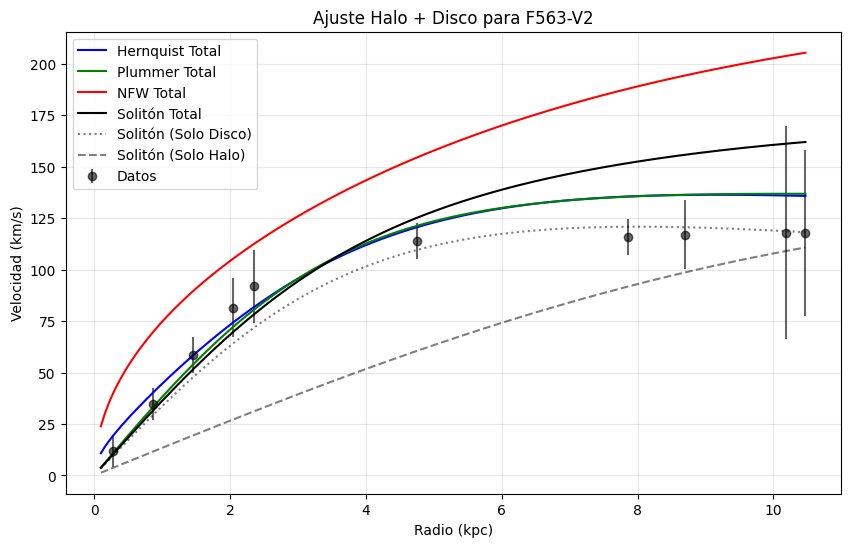

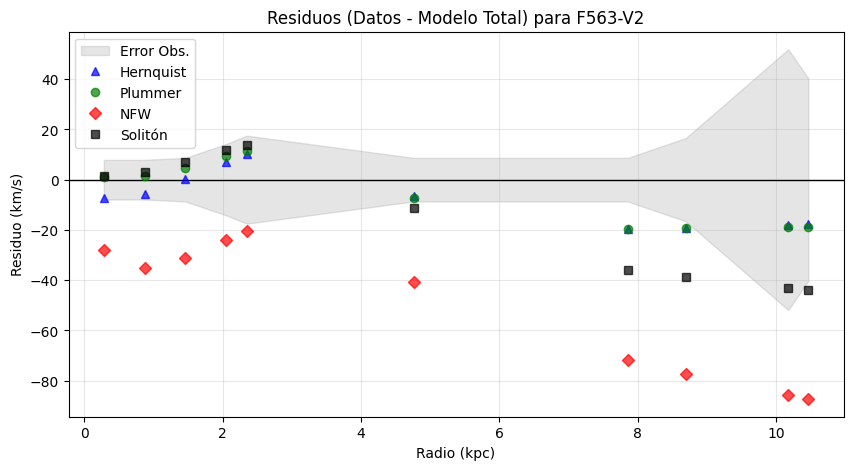


=== Resultados Galaxia: F568-1 (Halo + Disco Miyamoto-Nagai) ===
Modelo Plummer (χ²_red = 0.244)
  [Halo] M_halo  : 1.00e+11 ± 1.6e+12
  [Halo] a_halo  : 20.02 ± 181.63 kpc
  [Disco] Masa    : 5.00e+10 ± 1.1e+11 M⊙
  [Disco] a (rad) : 4.54 ± 6121715.23 kpc
  [Disco] b (vert): 1.04 ± 6121713.76 kpc
--------------------------------------------------
Modelo Hernquist (χ²_red = 0.666)
  [Halo] M_halo  : 1.00e+11 ± 8.9e+11
  [Halo] a_halo  : 20.05 ± 94.88 kpc
  [Disco] Masa    : 5.00e+10 ± 6.2e+10 M⊙
  [Disco] a (rad) : 4.81 ± 5592490.07 kpc
  [Disco] b (vert): 1.31 ± 5592489.48 kpc
--------------------------------------------------
Modelo Solitón (χ²_red = 3.769)
  [Halo] ρc_halo : 1.00e+07 ± 5.5e+07
  [Halo] a_halo  : 9.23 ± 22.15 kpc
  [Disco] Masa    : 5.00e+10 ± 1.9e+11 M⊙
  [Disco] a (rad) : 4.83 ± 6984605.99 kpc
  [Disco] b (vert): 1.33 ± 6984604.90 kpc
--------------------------------------------------
Modelo NFW (χ²_red = 39.779)
  [Halo] A_halo  : 1.00e+11 ± 9.3e+11
  [Halo] rs_h

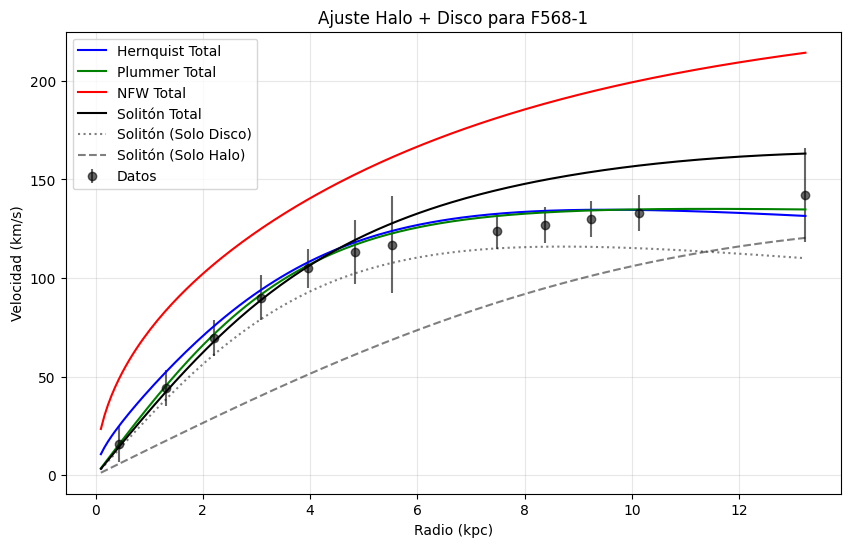

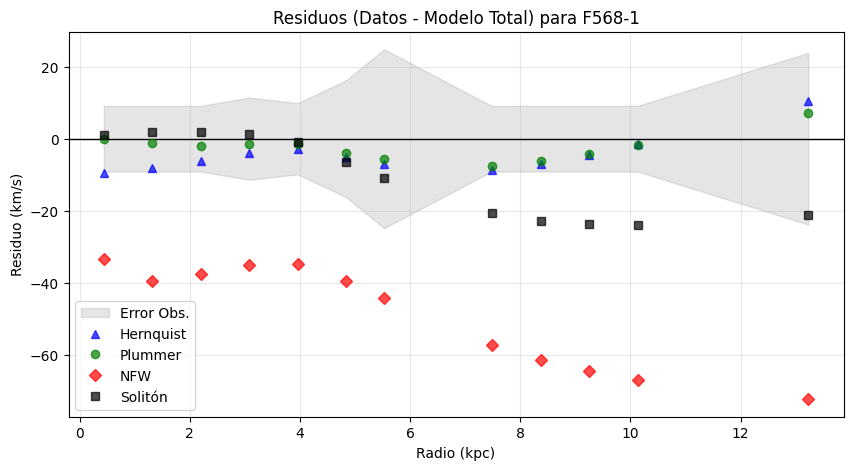


=== Resultados Galaxia: F568-3 (Halo + Disco Miyamoto-Nagai) ===
Modelo Plummer (χ²_red = 11.327)
  [Halo] M_halo  : 1.00e+11 ± 2.6e+11
  [Halo] a_halo  : 20.02 ± 42.04 kpc
  [Disco] Masa    : 5.00e+10 ± 5.4e+10 M⊙
  [Disco] a (rad) : 5.13 ± 7598943.66 kpc
  [Disco] b (vert): 1.63 ± 7598943.35 kpc
--------------------------------------------------
Modelo Hernquist (χ²_red = 22.064)
  [Halo] M_halo  : 1.00e+11 ± 3.8e+11
  [Halo] a_halo  : 20.07 ± 41.98 kpc
  [Disco] Masa    : 5.00e+10 ± 4.3e+10 M⊙
  [Disco] a (rad) : 5.46 ± 9457508.94 kpc
  [Disco] b (vert): 1.96 ± 9457509.98 kpc
--------------------------------------------------
Modelo Solitón (χ²_red = 26.866)
  [Halo] ρc_halo : 1.00e+07 ± 1.8e+07
  [Halo] a_halo  : 9.49 ± 5.38 kpc
  [Disco] Masa    : 5.00e+10 ± 8.3e+10 M⊙
  [Disco] a (rad) : 5.29 ± 4259534.00 kpc
  [Disco] b (vert): 1.79 ± 4259533.50 kpc
--------------------------------------------------
Modelo NFW (χ²_red = 226.642)
  [Halo] A_halo  : 1.00e+11 ± 2.3e+11
  [Halo] rs

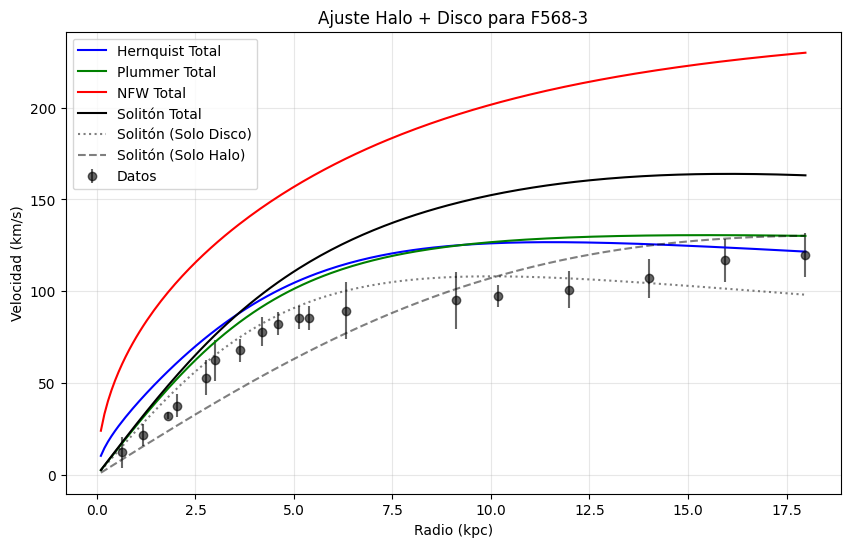

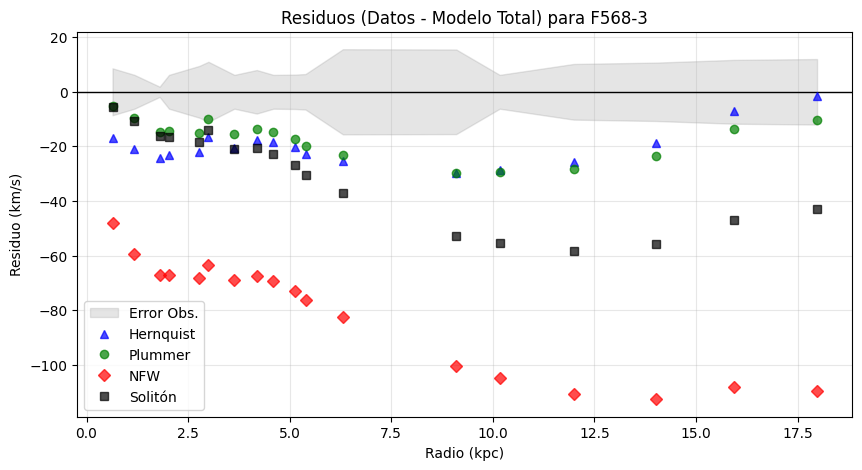

In [ ]:
# Lista de archivos de galaxias que quieres analizar
galaxy_files = [
    '/content/F563-1_rotmod.dat',
    '/content/F563-V2_rotmod.dat',
    '/content/F568-1_rotmod.dat',
    '/content/F568-3_rotmod.dat'
]

# Un diccionario para guardar todos los resultados si los necesitas después
resultados = {}

# Itera sobre cada archivo, realiza el análisis completo y muestra los resultados
for file in galaxy_files:
    galaxy_name = os.path.basename(file).split('_')[0]
    results = fit_and_plot_rotation_curve(
        file_path=file,
        show_plot=True,
        save_plot_path=False
        # save_plot_path=f"{galaxy_name}_fit.pdf"
    )

    if results:
        resultados[galaxy_name] = results